# Import packages, load data #

In [1]:
### IMPORT
### GENERAL PACKAGES
import numpy as np, pandas as pd
import os

### SETUP
pd.set_option('display.max_columns', None)

### PLOTTING
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.tree import plot_tree

### DATA MANIPULATION
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

### MODELS
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB, ComplementNB, BernoulliNB

### EXPORTING MODELS
import pickle

### VALIDATION
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

In [2]:
# LOOK FOR FILES
!ls /kaggle/input/titanic/

gender_submission.csv  test.csv  train.csv


In [3]:
# LOAD DATA
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

# Exploratory Data Analysis (EDA) #

# Inspect data for completeness #

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<div class= 'alert alert-block alert-danger'>
<b>Missing train data:</b>

* 891 entries, with data types int64, float64, and string
* many entries missing from AGE and, especially, CABIN
</div>

## Creating the FAMILY feature ##

In [7]:
# FAMILY = PARCH + SIBSP
# DEFINE FUNCTION TO ASSIGN FAMILY VALUES BASED ON PARCH AND SIBSP
def fam(parch:int, sibsip:int):
    if (parch==0) & (sibsip==0):
        return 'no'
    else:
        return 'yes'

# APPLY FUNCTION
df_train['Family'] = df_train.apply(lambda x: fam(x.Parch, x['SibSp']), axis=1)
df_test['Family'] = df_test.apply(lambda x: fam(x.Parch, x['SibSp']), axis=1)

In [8]:
def count_records(featcounts:str, feat:str, norecord:bool):
    """
    Counts FEATCOUNTS occurrences of each category of SEX, PCLASS, EMBARKED, FAMILY=SIBSP+PARCH
    for cases where FEAT={AGE,CABIN} records are absent or not (NORECORD={TRUE, FALSE})
    """
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Sex'] == 'male')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Sex'] == 'female')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 1)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 2)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 3)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'S')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'C')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'Q')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Family'] == 'yes')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Family'] == 'no')]))


In [9]:
# COUNTS OF NO AGE OR CABIN RECORD AT EACH PASSENGER CLASS, GENDER, PORT, FAMILY=SIBSP+PARCH
df_records = pd.DataFrame()
df_records['Feature'] = ['Gender(M)', 'Gender(F)', 'Class(1st)','Class(2nd)', 'Class(3rd)', 
                       'Port(Southampton)', 'Port(Cherbourg)', 'Port(Queenstown)', 
                       'Family(yes)', 'Family(no)']

counts_age = []; counts_noage = []; counts_cabin = []; counts_nocabin = []

count_records(counts_age, 'Age', False)
count_records(counts_noage, 'Age', True)
count_records(counts_cabin, 'Cabin', False)
count_records(counts_nocabin, 'Cabin', True)

df_records['Age_record'] = counts_age
df_records['No_age_record'] = counts_noage
df_records['Cabin_record'] = counts_cabin
df_records['No_cabin_record'] = counts_nocabin

print("""Number of passengers with/without AGE or CABIN records depending on GENDER, ticket CLASS,
port of EMBARKment, number of family members (SIBSP+PARCH) aboard:\n\n""", df_records)

Number of passengers with/without AGE or CABIN records depending on GENDER, ticket CLASS,
port of EMBARKment, number of family members (SIBSP+PARCH) aboard:

              Feature  Age_record  No_age_record  Cabin_record  No_cabin_record
0          Gender(M)         453            124           107              470
1          Gender(F)         261             53            97              217
2         Class(1st)         186             30           176               40
3         Class(2nd)         173             11            16              168
4         Class(3rd)         355            136            12              479
5  Port(Southampton)         554             90           129              515
6    Port(Cherbourg)         130             38            69               99
7   Port(Queenstown)          28             49             4               73
8        Family(yes)         310             44           110              244
9         Family(no)         404            133    

In [10]:
# CHECKING FOR DUPLICATED VALUES
df_train.duplicated().sum()

0

In [11]:
# CHECK TEST DATA
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Family       418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [12]:
df_test.duplicated().sum()

0

<div class="alert alert-block alert-info">
<b>Notes on data inspection:</b>

* TICKET data seems useless; some are strings with only numeric values, some are alphanumeric
* NAME data is useless and invasive
* missing data could stem from port services, due to a much larger volume of inbound passengers:
    * about 70% of missing AGE/CABIN data related to 3rd class ticket passengers, with a similar percentage for male passengers
    * Southampton was the embarcation port for 72% of all passengers
* majority of passengers without AGE or CABIN records have no family members aboard
</div>

<div class= 'alert alert-block alert-warning'>
<b>About train data completeness:</b>

* 891 entries, with data types int64, float64, and string
* 177 values missing from AGE field
* 687 values missing from CABIN field
* 2 values missing from EMBARK field
* no duplicate entries

<b>About test data completeness:</b>

* 418 entries, with data types int64, float64, and string
* test data also has missing values for AGE (327) and CABIN (86), and one missing entry for FARE
* no duplicate entries
</div>

## Extracting Titles from the NAME feature ##

In [13]:
# WRITE A FUNCTION TO SPLIT THE NAME STRING AND EXTRACT THE TITLE
def detach(inp):
    return list(inp.split(','))[1].split()[0]

# APPLY FUNCTION TO NAME FEATURE
df_train['Title'] = df_train['Name'].apply(lambda x: detach(x))
df_test['Title'] = df_test['Name'].apply(lambda x: detach(x))
# THERE IS A TITLE SPELLED "THE", WHICH BELONGS TO A COUNTESS: INDEX 759
df_train.loc[759,'Title'] = 'Countess'
# GROUP TITLES IN DICTIONARY
titledict = {}
titledict.update(dict.fromkeys(['Mr.'],'Mr'))
titledict.update(dict.fromkeys(['Miss.', 'Mrs.', 'Ms.'],'Miss'))
titledict.update(dict.fromkeys(['Master.', 'Dr.', 'Rev.'],'Professional'))
titledict.update(dict.fromkeys(['Don.', 'Sir.', 'Lady.', 'Mlle.', 'Mme.','Jonkheer', 'Countess', 'Major.', 'Col.', 'Capt.'],'Wealth'))

# CONVERT TITLES
df_train['Title'] = df_train['Title'].map(titledict)
df_test['Title'] = df_test['Title'].map(titledict)

## Filling the FARE field in test data ##

In [14]:
# CALCULATE MEDIAN OF FARE FOR RELEVANT PASSENGER FEATURES AND ASSIGN IT
df_test[df_test['Fare'].isna() == True]
# 3rd PCLASS, MALE, NO FAMILY, SOUTHAMPTON
med_fare = df_test[(df_test['Pclass'] == 3) & (df_test['Sex'] == 'male') & (df_test['Family'] == 'no') & (df_test['Embarked'] == 'S')]['Fare'].median()
df_test['Fare'] = df_test['Fare'].fillna(med_fare)

## Binning FARE into Quartiles ##

In [15]:
# BINNING FARE VALUES INTO QUARTILES
def bin_ages(age):
    q1 = df_train['Fare'].quantile(0.25)
    q2 = df_train['Fare'].quantile(0.50)
    q3 = df_train['Fare'].quantile(0.75)
    if age < q1:
        return 'Q1'
    elif age < q2:
        return 'Q2'
    elif age < q3:
        return 'Q3'
    elif age >= q3:
        return 'Q4'

df_train['Fare_Q'] = df_train.apply(lambda x: bin_ages(x['Fare']), axis=1)
df_test['Fare_Q'] = df_test.apply(lambda x: bin_ages(x['Fare']), axis=1)

## Filling the EMBARKED field ##

In [16]:
# THE TWO MISSING EMBARKED VALUES IN THE TRAIN DATA ARE FOR FIRST CLASS FEMALES WITHOUT FAMILY ABOARD
# SHARING A CABIN, SO THE PORT COULD BE THE SAME
df_train[df_train['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Title,Fare_Q
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,no,Miss,Q4
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,no,Miss,Q4


In [17]:
# LOOKING AT RECORDS FROM FEMALES, WITHOUT FAMILY, FIRST CLASS
print(df_train[(df_train['Pclass'] == 1) & (df_train['Family'] == 'no') & (df_train['Sex'] == 'female')].groupby('Embarked')['PassengerId'].count())
# OVER 50% PROBABILITY THAT BOTH CAME FROM CHERBOURG, SO WE'LL ASSIGN THAT AS EMBARKED PORT
df_train['Embarked'].fillna('C', inplace=True)

Embarked
C    18
S    14
Name: PassengerId, dtype: int64


<div class="alert alert-block alert-warning">
Two missing train data entries in the EMBARKED field were assigned the C=Cherbourg value, the most populated one for their SEX, FAMILY, and PCLASS records
</div>

## Creating the CabinId feature ##

In [18]:
# COUNTS OF CABIN IDENTIFIERS INCLUDING ONLY DIGITS (NOT LETTERS)
df_train['Cabin'].str.isnumeric().value_counts()

Cabin
False    204
Name: count, dtype: int64

In [19]:
# GET CABIN IDENTIFIER LETTER(S)
# THERE ARE TOO MANY CABINID CATEGORIES (EX: B, BB, BBB, BBBB), SO WE'LL KEEP ONLY THE FIRST LETTER
# THIS MEANS, FROM 1ST TO 3RD CLASS: T, A, B, C, D, E, F, G
def firstlet(cabin:str):
    #if cabin != np.NaN:
    if pd.isna(cabin)==False:
        return str(cabin)[0]

df_train['CabinId'] = df_train['Cabin'].apply(firstlet)

# FOR THE TEST DATA
df_test['CabinId'] = df_test['Cabin'].apply(firstlet)

In [20]:
df_train.groupby(['Pclass', 'CabinId']).PassengerId.count()

Pclass  CabinId
1       A          15
        B          47
        C          59
        D          29
        E          25
        T           1
2       D           4
        E           4
        F           8
3       E           3
        F           5
        G           4
Name: PassengerId, dtype: int64

<div class="alert alert-block alert-info">
<b>About lack of AGE and CABIN records:</b>

* AGE/CABIN records, both missing and existing, follow SEX, PCLASS, EMBARK, PARCH+SIBSP records
    * this is related to the large proportion of SEX=male, PCLASS=3, EMBARK=S, and PARCH+SIBSP=0
* there are sufficient AGE data that missing AGE records can be estimated
    * regression model
    * random sampling from distribution
    * NaiveBayes
* for CABIN data, there are many more missing data points
    * all CABIN data start with one or more alphabet characters, from which CABINID was built
    * CABINID varies the most with PCLASS
        * CABINID can be estimated
</div>

<div class="alert alert-block alert-success">
<b>Conclusions on data inspection:</b>
    
* PASSENGERID, TICKET, and NAME fields will be dropped
* AGE and CABINID fields will be completed by Gaussian NaiveBayes
</div>

## Filling the CABINID field ##

<div class="alert alert-block alert-danger">
ENTRY 339 WAS PERMANENTLY DELETED!
</div>

In [21]:
# CBN_COMP=T IS A SINGLE ENTRY FOR THE CABIN, AND MAY RESULT IN PROBLEMS LATER ON
# WE WILL ELIMINATE THIS ENTRY PERMANENTLY (INDEX 339)
df_train = df_train.drop(index=339).reset_index(drop=True)

<div class="alert alert-block alert-danger">
ENTRY 339 WAS PERMANENTLY DELETED!
</div>

In [22]:
# PEARSON CORRELATION BETWEEN CABINID AND OTHER FEATURES
crl = pd.get_dummies(df_train.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin'], axis=1)).corr()
crl.iloc[-8:,:-9]

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_no,Family_yes,Title_Miss,Title_Mr,Title_Professional,Title_Wealth,Fare_Q_Q1,Fare_Q_Q2
Fare_Q_Q4,-0.587522,0.096630,0.321022,0.293699,0.652874,0.178641,-0.178641,0.231925,-0.160060,-0.103114,-0.364490,0.364490,0.160447,-0.214373,0.072870,0.111789,-0.335333,-0.329313
CabinId_A,-0.205450,0.136611,-0.046342,-0.040401,0.019559,-0.078404,0.078404,0.091814,-0.040294,-0.055304,0.052902,-0.052902,-0.095248,0.040733,0.003937,0.211744,-0.055563,-0.074347
CabinId_B,-0.370510,0.094375,-0.034669,0.056381,0.386328,0.109530,-0.109530,0.191990,-0.072667,-0.122923,-0.064725,0.064725,0.081685,-0.114498,-0.016959,0.190196,-0.101749,-0.134078
CabinId_C,-0.418109,0.122553,0.029113,0.030599,0.364353,0.058449,-0.058449,0.111789,-0.049873,-0.066827,-0.124871,0.124871,0.052993,-0.047640,-0.028883,0.047166,-0.154069,-0.151303
CabinId_D,-0.279427,0.137402,-0.017682,-0.019233,0.098895,0.079111,-0.079111,0.101300,-0.060390,-0.051015,-0.083518,0.083518,0.069747,-0.049786,-0.024252,-0.022941,-0.113463,-0.056032
CabinId_E,-0.230754,0.121848,-0.036974,-0.016659,0.053732,0.046858,-0.046858,-0.017078,-0.037966,0.038828,-0.028014,0.028014,0.049804,-0.031213,-0.023095,-0.022577,-0.111666,-0.011276
CabinId_F,0.010864,-0.083851,0.001642,0.023632,-0.033085,0.008104,-0.008104,-0.035336,-0.004155,0.033629,-0.015867,0.015867,0.009866,-0.048138,0.088087,-0.014234,0.016051,-0.003701
CabinId_G,0.055520,-0.077246,-0.001438,0.072362,-0.025175,0.091004,-0.091004,-0.032649,-0.020678,0.041644,-0.082679,0.082679,0.092363,-0.078923,-0.016908,-0.007855,-0.038851,0.040088


In [23]:
# CREATE FUNCTION TO READ FEATURES WITH HIGHEST CORRELATION WITH CABINID,
# FOR EACH CABINID=NaN ENTRY, EXTRACT ALL CABINID VALUES FOR SIMILAR FEATURES, 
# AND ASSIGN A RANDOMLY SAMPLED CABINID VALUE
def testf(pclass:int, family:str, fare_q:str, sex:str, cabinid:str):
    if pd.isnull(cabinid) == True:
        df = df_train[df_train['CabinId'].isna() == False]
        cbn_list = list(df[(df['Pclass'] == pclass) & (df['Family'] == family) & (df['Fare_Q'] == fare_q) & (df['Sex'] == sex)]['CabinId'])
        if len(cbn_list) != 0:
            return np.random.choice(cbn_list)
        else:
            # MOST COMMON CABINID VALUE IS C
            return 'C'
    else:
        return cabinid
# RUN FUNCTION OVER CABINID
df_train['CabinId'] = df_train.apply(lambda x: testf(x['Pclass'], x['Family'], x['Fare_Q'], x['Sex'], x['CabinId']), axis=1)
# FOR TEST DATA, USING THE SAME FUNCTION AS FOR THE TRAIN DATA
df_test['CabinId'] = df_test.apply(lambda x: testf(x['Pclass'], x['Family'], x['Fare_Q'], x['Sex'], x['CabinId']), axis=1)

## Filling the AGE field ##

In [24]:
# PEARSON CORRELATION BETWEEN AGE AND OTHER FEATURES
crl = pd.get_dummies(df_train.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin'], axis=1)).corr()
crl.loc['Age'].sort_values()

Pclass               -0.367893
SibSp                -0.307737
Title_Professional   -0.288766
Family_yes           -0.197235
Parch                -0.188552
CabinId_G            -0.147794
CabinId_C            -0.141806
Title_Miss           -0.097531
Sex_female           -0.092241
CabinId_F            -0.066563
Fare_Q_Q1            -0.046550
Embarked_S           -0.033350
Fare_Q_Q3            -0.032820
Fare_Q_Q2            -0.022807
Embarked_Q           -0.022124
Embarked_C            0.046886
CabinId_E             0.062580
Sex_male              0.092241
Fare                  0.096119
Fare_Q_Q4             0.096630
CabinId_B             0.118479
CabinId_A             0.120142
Title_Wealth          0.126846
CabinId_D             0.164097
Family_no             0.197235
Title_Mr              0.205298
Age                   1.000000
Name: Age, dtype: float64

In [25]:
# CREATE FUNCTION TO READ FEATURES WITH HIGHEST CORRELATION WITH AGE,
# FOR EACH AGE=NaN ENTRY, EXTRACT ALL AGE VALUES FOR SIMILAR FEATURES, 
# AND ASSIGN A RANDOMLY SAMPLED AGE VALUE
def testf(pclass:int, family:str, sibsp:str, parch:str, cabinid:str, age:int):
    if pd.isnull(age) == True:
        df = df_train[df_train['Age'].isna() == False]
        age_list = list(df[(df['Pclass'] == pclass) & (df['Family'] == family) & (df['SibSp'] == sibsp) & (df['Parch'] == parch) & (df['CabinId'] == cabinid)]['Age'])
        if len(age_list) != 0:
            return np.random.choice(age_list)
        else:
            # MOST COMMON AGE VALUE IS 22.0
            return 22.0
    else:
        return age
# RUN FUNCTION OVER AGE
df_train['Age_new'] = df_train.apply(lambda x: testf(x['Pclass'], x['Family'], x['SibSp'], x['Parch'], x['CabinId'], x['Age']), axis=1)
# FOR TEST DATA, USING THE SAME FUNCTION AS FOR THE TRAIN DATA
df_test['Age_new'] = df_test.apply(lambda x: testf(x['Pclass'], x['Family'], x['SibSp'], x['Parch'], x['CabinId'], x['Age']), axis=1)
# CALCULATE QUARTILE VALUES
Q1 = df_train['Age_new'].quantile(0.25)
Q2 = df_train['Age_new'].quantile(0.50)
Q3 = df_train['Age_new'].quantile(0.75)
# FUNCTION FOR RANKING AGE INTO QUARTILES USING TRAINING DATA INTERVALS
def quart(inp):
    if inp <= Q1:
        return 'Q1'
    elif inp <= Q2:
        return 'Q2'
    elif inp <= Q3:
        return 'Q3'
    else:
        return 'Q4'
# CONVERT AGE INTO QUARTILES
df_train['Age_Q'] = df_train['Age_new'].apply(lambda x: quart(x))

# FOR TEST DATA
df_test['Age_Q'] = df_test['Age_new'].apply(lambda x: quart(x))

## Data distributions ##

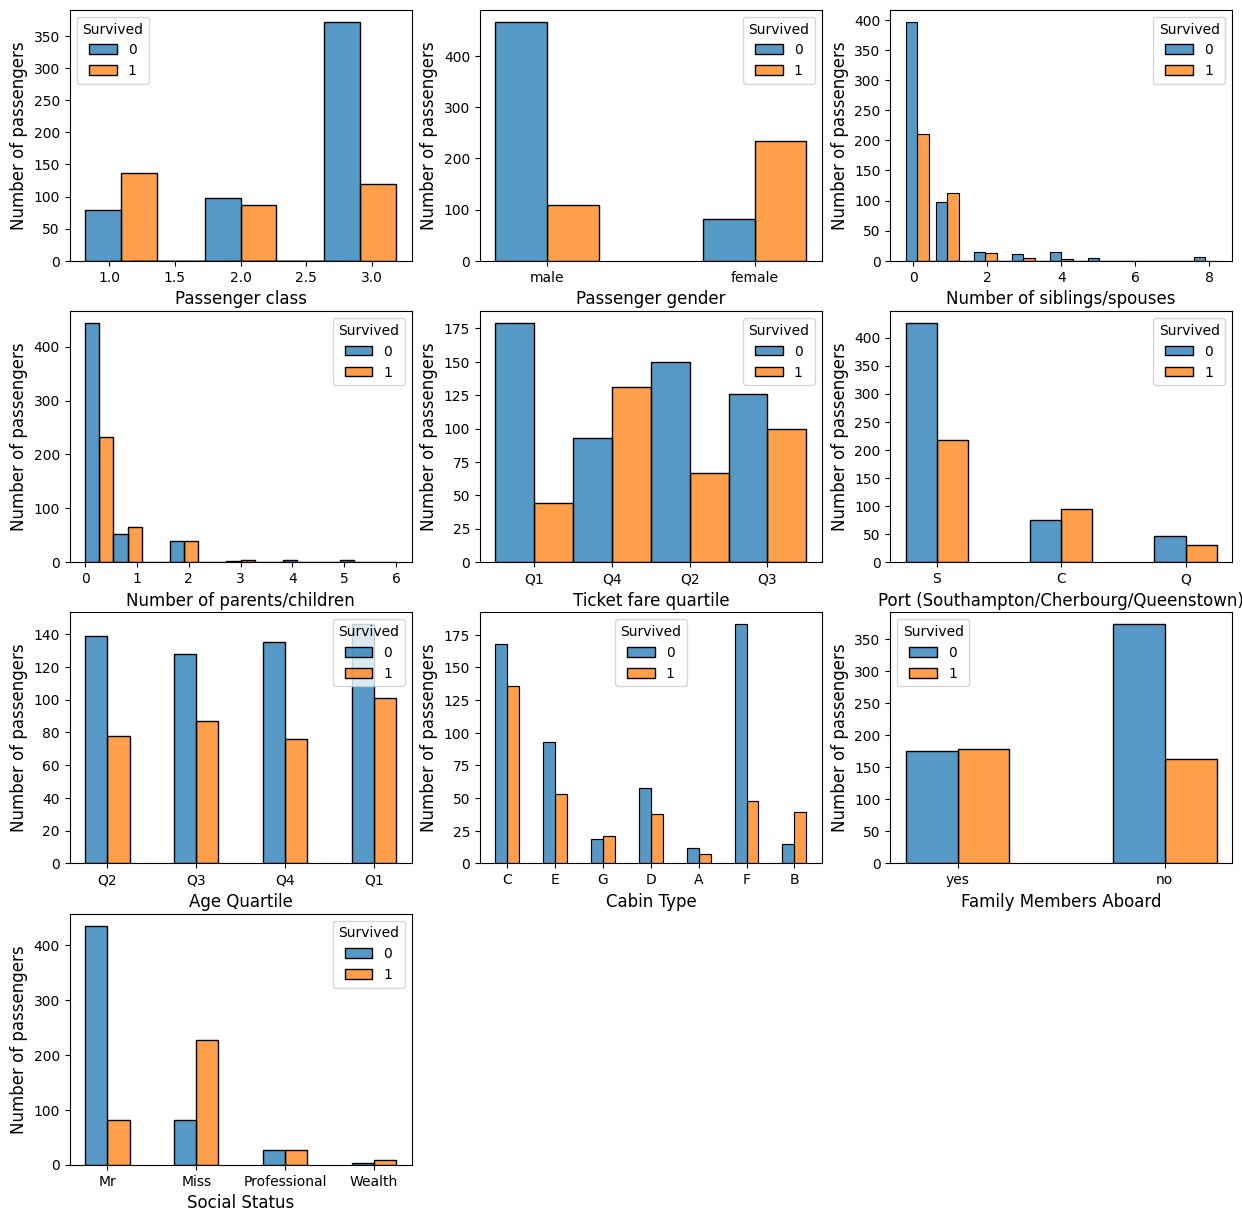

In [26]:
# ONE-DIMENSIONAL DISTRIBUTIONS
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (15,15))
gs = plt.GridSpec(4,3, height_ratios=(1,1,1,1))

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
g6 = plt.subplot(gs[1, 2])
g7 = plt.subplot(gs[2, 0])
g8 = plt.subplot(gs[2, 1])
g9 = plt.subplot(gs[2, 2])
g10 = plt.subplot(gs[3, 0])


ax1 = sns.histplot(ax=g1, data = df_train, x='Pclass',hue = 'Survived', stat='count', multiple='dodge',shrink=3)
ax1.set_xlabel('Passenger class', fontsize=12)
ax1.set_ylabel('Number of passengers', fontsize=12)

ax2 = sns.histplot(ax=g2, data = df_train, x='Sex',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax2.set_xlabel('Passenger gender', fontsize=12)
ax2.set_ylabel('Number of passengers', fontsize=12)

ax3 = sns.histplot(ax=g3, data = df_train, x='SibSp',hue = 'Survived', stat='count', multiple='dodge',shrink=3)
ax3.set_xlabel('Number of siblings/spouses', fontsize=12)
ax3.set_ylabel('Number of passengers', fontsize=12)

ax4 = sns.histplot(ax=g4, data = df_train, x='Parch',hue = 'Survived', stat='count', multiple='dodge')
ax4.set_xlabel('Number of parents/children', fontsize=12)
ax4.set_ylabel('Number of passengers', fontsize=12)

ax5 = sns.histplot(ax=g5, data = df_train, x='Fare_Q',hue = 'Survived', stat='count', multiple='dodge')
ax5.set_xlabel('Ticket fare quartile', fontsize=12)
ax5.set_ylabel('Number of passengers', fontsize=12)

ax6 = sns.histplot(ax=g6, data = df_train, x='Embarked',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax6.set_xlabel('Port (Southampton/Cherbourg/Queenstown)', fontsize=12)
ax6.set_ylabel('Number of passengers', fontsize=12)

ax7 = sns.histplot(ax=g7, data = df_train, x='Age_Q',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax7.set_xlabel('Age Quartile', fontsize=12)
ax7.set_ylabel('Number of passengers', fontsize=12)

ax8 = sns.histplot(ax=g8, data = df_train, x='CabinId',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax8.set_xlabel('Cabin Type', fontsize=12)
ax8.set_ylabel('Number of passengers', fontsize=12)

ax9 = sns.histplot(ax=g9, data = df_train, x='Family',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax9.set_xlabel('Family Members Aboard', fontsize=12)
ax9.set_ylabel('Number of passengers', fontsize=12)

ax10 = sns.histplot(ax=g10, data = df_train, x='Title',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax10.set_xlabel('Social Status', fontsize=12)
ax10.set_ylabel('Number of passengers', fontsize=12)

fig.show()

<div class='alert alert-block alert-info'>
<b>Probability of surviving appears to depend on:</b>
    
* PCLASS: a first class passenger is most likely to survive, those in 3rd class are less likely to survive
    * a similar number of passengers from each class have survived, in spite of a much larger total number of 3rd class passengers - 3rd class seems to be a good predictor for _not_ surviving
* SEX: males are less likely to survive
* SIBSP/PARCH: people without family members aboard are less likely to survive
* FARE: passengers who paid lower ticket fares are less likely to survive
* EMBARKED: passengers who embarked in Southampton are less likely to survive
* AGE_COMP: children (~5 years old) are likelier to survive
* CABINID: passengers of cabin type B, C, E are more likely to survive
* FAMILY: passengers with family members aboard are more likely to survive, without family are less likely
</div>

# Modeling #

<div class="alert alert-block alert-info">
<b>Modeling strategy:</b>
    
* We will calibrate a series of models, to be used collectively for the final prediction

## Set-up variables, convert and scale data ##

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  890 non-null    int64  
 1   Survived     890 non-null    int64  
 2   Pclass       890 non-null    int64  
 3   Name         890 non-null    object 
 4   Sex          890 non-null    object 
 5   Age          713 non-null    float64
 6   SibSp        890 non-null    int64  
 7   Parch        890 non-null    int64  
 8   Ticket       890 non-null    object 
 9   Fare         890 non-null    float64
 10  Cabin        203 non-null    object 
 11  Embarked     890 non-null    object 
 12  Family       890 non-null    object 
 13  Title        889 non-null    object 
 14  Fare_Q       890 non-null    object 
 15  CabinId      890 non-null    object 
 16  Age_new      890 non-null    float64
 17  Age_Q        890 non-null    object 
dtypes: float64(3), int64(5), object(10)
memory usage: 

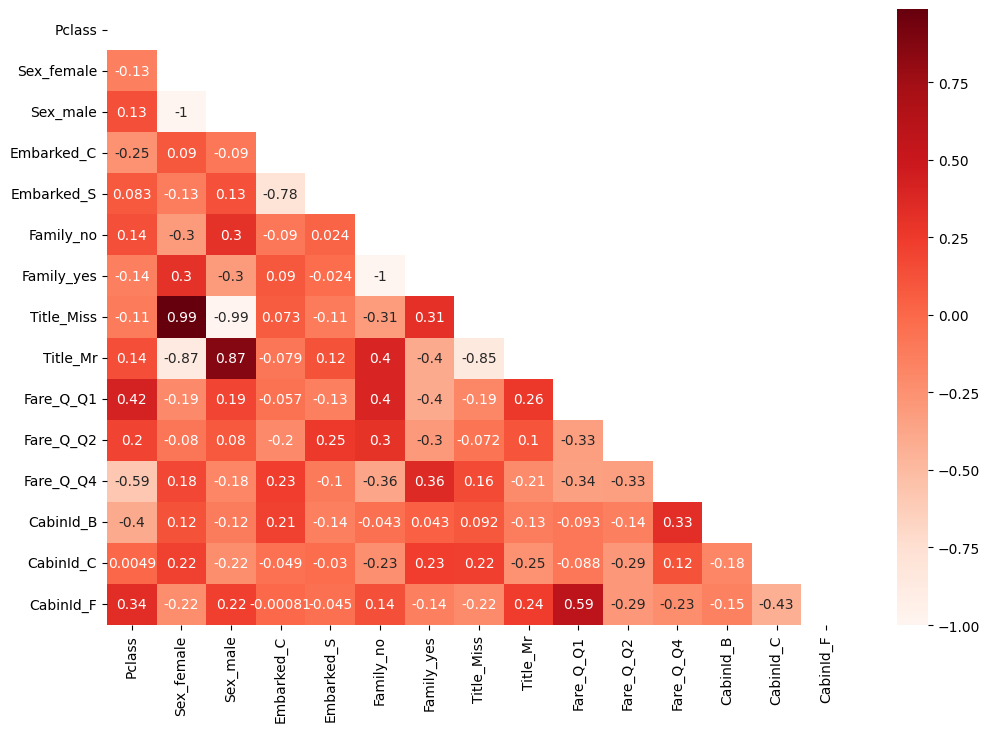

In [28]:
# DEFINE PREDICTOR AND OUTCOME VARIABLES, DROP USELESS FIELDS
X = df_train.drop(['Survived', 'PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Age_new'], axis=1)
y = df_train['Survived']
X_test = df_test.drop(['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Age_new'], axis=1)

# CONVERT CATEGORICAL DATA FOR LOGISTIC REGRESSION CLASSIFIER WITH ONE-HOT ENCODING
Xncd = pd.get_dummies(X, drop_first=False)
Xncd_test = pd.get_dummies(X_test, drop_first=False)
# SELECT TOP 15 FEATURES BASED ON ANOVA F-TEST
feat_index = SelectKBest(k=15).fit(Xncd,y).get_support(indices=True)
Xncd = Xncd.iloc[:,feat_index]
Xncd_test = Xncd_test.iloc[:,feat_index]
# PLOT PEARSON CORRELATION BETWEEN FEATURES
corr = Xncd.corr()
uppertri = np.triu(corr)
fig = plt.figure(figsize=(12,8))
ax1=sns.heatmap(corr, annot=True, cmap='Reds', mask=uppertri)
fig.show()

In [29]:
# GET ROW AND COLUMN NUMBERS FOR -0.5 < PEARSON CORRELATION < 0.5 (USING ONLY LOWER HALF OF CORRELATION MATRIX)
row,col =  np.nonzero((abs(np.triu(corr))>0.5))
# REMOVE REPEATED ENTRIES, E.G. 1,2 AND 2,1
lrow = [int(i) if i!=j else '' for i,j in zip(row,col)]
# REMOVE COLUMNS FROM Xncd
colname = []
for i,j in enumerate(corr.columns):
    if i in lrow:
        colname.append(j)

Xncd = Xncd.drop(colname, axis=1)
Xncd_test = Xncd_test.drop(colname, axis=1)

# SPLIT DATA INTO TRAINING AND TRIAL
X_train, X_trial, y_train, y_trial = train_test_split(Xncd, y, test_size=0.25, stratify=y, random_state=0)

## Fit model: Logistic Regression ##

                          precision    recall  f1-score   support

Predicted not to survive       0.80      0.81      0.81       137
    Predicted to survive       0.69      0.69      0.69        86

                accuracy                           0.76       223
               macro avg       0.75      0.75      0.75       223
            weighted avg       0.76      0.76      0.76       223



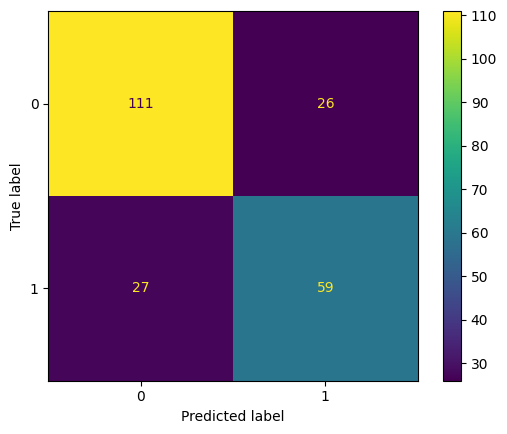

CPU times: user 926 ms, sys: 220 ms, total: 1.15 s
Wall time: 914 ms


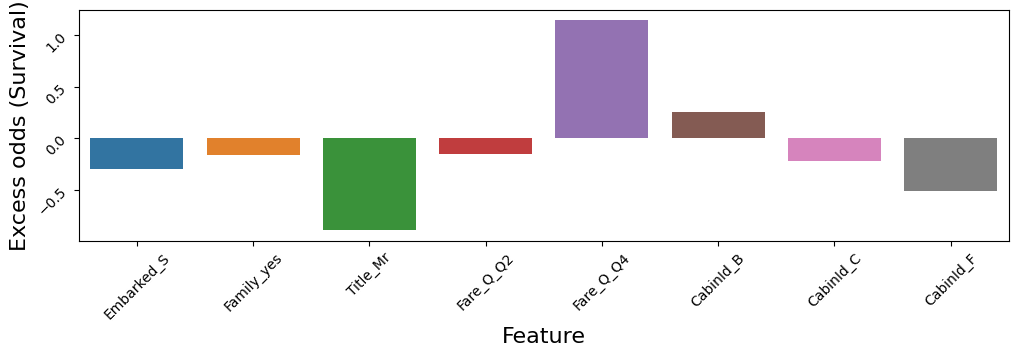

In [30]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# CV PARAMETERS
model_lg = LogisticRegressionCV(Cs = 50, cv = 5, scoring = 'f1', max_iter = 1000, tol=0.0001,refit=True)
# FIT MODEL
model_lg.fit(X_train, y_train)

# MAKE PREDICTIONS ON TRIAL DATA
preds_lg = model_lg.predict(X_trial)
# MAKE PREDICTIONS ON TEST DATA
preds_lg_test = model_lg.predict(Xncd_test)
# Create classification report for logistic regression model
labels = ['Predicted not to survive', 'Predicted to survive']
print(classification_report(y_trial, preds_lg, target_names=labels))
# PLOT CONFUSION MATRIX
cm = confusion_matrix(y_trial, preds_lg, labels = model_lg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_lg.classes_)
disp.plot(values_format='')
plt.show()

# FEATURE IMPORTANCE
fig = plt.figure(figsize = (12,3))
ax1=sns.barplot(x=X_train.columns, y=(np.exp(model_lg.coef_.flatten())-1))
ax1.set_xlabel('Feature', fontsize=16)
ax1.set_ylabel('Excess odds (Survival)', fontsize=16)
ax1.tick_params(rotation = 45)
fig.show()

## Fit model: Random Forest ##

In [31]:
%%time
# DETERMINE HYPERPARAMETERS FOR CROSS-VALIDATION
cv_params = {'criterion': ['entropy'], 
             'max_depth' : [10,15,20], 
             'max_features' : [8, 12, 14], 
             'max_samples' : [0.7, 0.9], 
             'min_samples_leaf' : [0.001,0.005,0.01], 
             'min_samples_split' : [0.001,0.005,0.01], 
             'n_estimators' : [150,200, 250]}
# INSTANTIATE MODEL
model_rf = RandomForestClassifier(random_state=0)
model_rf_val = GridSearchCV(model_rf, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)
# FIT THE MODEL
#model_rf_val.fit(X_train, y_train)
# GET BEST PARAMETERS
#print(model_rf_val.best_params_)

CPU times: user 80 µs, sys: 0 ns, total: 80 µs
Wall time: 83.4 µs


                          precision    recall  f1-score   support

Predicted not to survive       0.82      0.81      0.81       137
    Predicted to survive       0.70      0.71      0.71        86

                accuracy                           0.77       223
               macro avg       0.76      0.76      0.76       223
            weighted avg       0.77      0.77      0.77       223



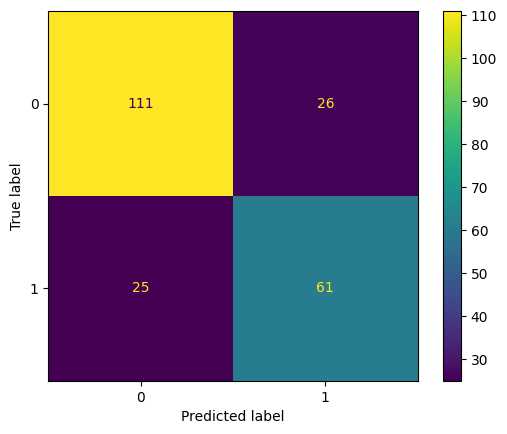

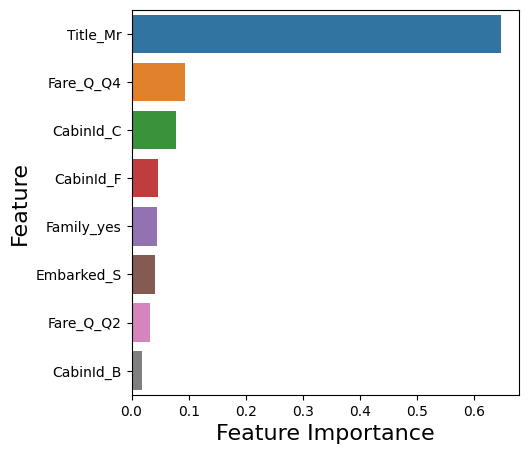

In [32]:
# PARAMETERS FOR RE-FITTING
model_rf_opt = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 8, max_samples = 0.7,
                                min_samples_leaf = 0.01, min_samples_split = 0.001, n_estimators = 150, random_state = 0)
# RE-FIT MODEL USING BEST PARAMETERS
model_rf_opt.fit(X_train, y_train)
# MAKE PREDICTIONS ON TRIAL DATA
preds_rf = model_rf_opt.predict(X_trial)
# MAKE PREDICTIONS ON TEST DATA
preds_rf_test = model_rf_opt.predict(Xncd_test)
# Create classification report for logistic regression model
labels = ['Predicted not to survive', 'Predicted to survive']
print(classification_report(y_trial, preds_rf, target_names=labels))
# PLOT CONFUSION MATRIX
cm = confusion_matrix(y_trial, preds_rf, labels = model_rf_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_rf_opt.classes_)
disp.plot(values_format='')
plt.show()

# FEATURE IMPORTANCE WITHIN RANDOM FOREST MODEL
fig = plt.figure(figsize=(5,5))
importance = pd.DataFrame()
importance['Feature'] = X_trial.columns
importance['Importance'] = model_rf_opt.feature_importances_
importance = importance.sort_values(by='Importance', ascending=False)
ax = sns.barplot(data=importance, x='Importance', y='Feature', orient='h')
ax.set_xlabel('Feature Importance', fontsize=16)
ax.set_ylabel('Feature', fontsize=16)
fig.show()

## Fit model: XGB ##

In [33]:
%%time
# DETERMINE HYPERPARAMETERS FOR CROSS-VALIDATION
cv_params = {'max_depth' : [4, 6, 8],
            'n_estimators' : [150, 200, 250],
            'learning_rate' : [0.1, 0.2, 0.3],
            'colsample_bytree' : [0.7, 0.8, 0.9],
            'min_child_weight': [5, 7, 10],
             'gamma' : [0.7, 0.8, 0.9],
            'subsample' : [0.5, 0.7, 0.9]}
# INSTANTIATE MODEL
model_xgb = XGBClassifier(objective = 'binary:logistic')
# SET CROSS-VALIDATION RUN
model_xgb_val = GridSearchCV(model_xgb, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)
# FIT THE MODEL
#model_xgb_val.fit(X_train, y_train)
# GET BEST PARAMETERS
#print(model_xgb_val.best_params_)

CPU times: user 45 µs, sys: 10 µs, total: 55 µs
Wall time: 58.9 µs


                          precision    recall  f1-score   support

Predicted not to survive       0.82      0.81      0.81       137
    Predicted to survive       0.70      0.71      0.71        86

                accuracy                           0.77       223
               macro avg       0.76      0.76      0.76       223
            weighted avg       0.77      0.77      0.77       223



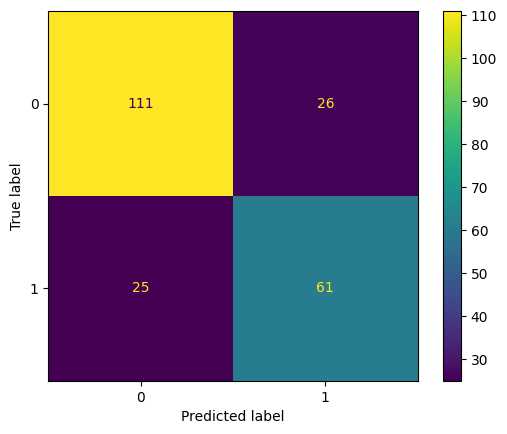

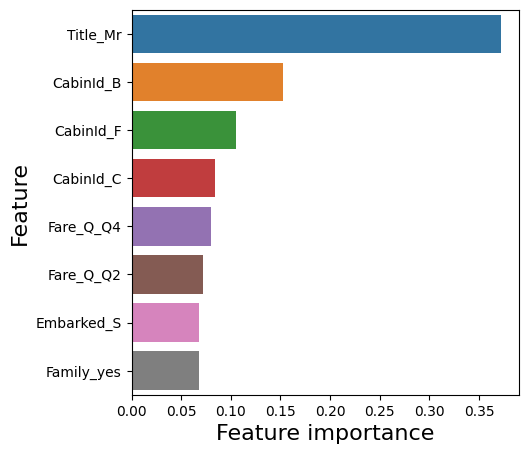

In [34]:
# BEST FIT PARAMETERS
model_xgb_opt = XGBClassifier(colsample_bytree = 0.7, gamma=0.8, learning_rate=0.3, max_depth = 4,
                                min_child_weight = 5, n_estimators = 150, subsample = 0.7, random_state = 0)
# RE-FIT MODEL
model_xgb_opt.fit(X_train, y_train)
# USE MODEL TO MAKE PREDICTIONS ON TRIAL DATASET
preds_xgb = model_xgb_opt.predict(X_trial)
# MAKE PREDICTIONS ON TEST DATA
preds_xgb_test = model_xgb_opt.predict(Xncd_test)
# CLASSIFICATION REPORT FOR XGB MODEL
labels = ['Predicted not to survive', 'Predicted to survive']
print(classification_report(y_trial, preds_xgb, target_names=labels))
# PLOT CONFUSION MATRIX FOR XBG MODEL
cm = confusion_matrix(y_trial, preds_xgb, labels = model_xgb_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_xgb_opt.classes_)
disp.plot(values_format='')
plt.show()

# FEATURE IMPORTANCE WITHIN XBG MODEL
fig = plt.figure(figsize=(5,5))
importance = pd.DataFrame()
importance['Feature'] = X_trial.columns
importance['Importance'] = model_xgb_opt.feature_importances_
importance = importance.sort_values(by='Importance', ascending=False)
ax = sns.barplot(data=importance, x='Importance', y='Feature', orient='h')
ax.set_xlabel('Feature importance', fontsize=16)
ax.set_ylabel('Feature', fontsize=16)
fig.show()

## Fit model: (Linear) Support Vector Classifier ##

In [35]:
%%time
# SCALE THE PREDICTOR FEATURES so that mean=0 and std=1
#scaler = StandardScaler().fit_transform(X_train)
# TRANSFORM SCALED SETS BACK TO DATAFRAME FORMAT
#X_train = pd.DataFrame(scaler, columns = X_train.columns)
# DETERMINE HYPERPARAMETERS FOR CROSS-VALIDATION
cv_params = {'dual' : [False],
            'tol' : [0.0001, 0.000001],
            'C' : [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
            'class_weight' : [None, 'balanced'],
            'max_iter' : [1000, 10000, 100000, 1000000]}
# INSTANTIATE MODEL
model_svc = LinearSVC(fit_intercept=True, random_state=0)
# SET CROSS-VALIDATION RUN
model_svc_val = GridSearchCV(model_svc, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)
# FIT THE MODEL
model_svc_val.fit(X_train, y_train)
# GET BEST PARAMETERS
print(model_svc_val.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'max_iter': 1000, 'tol': 0.0001}
CPU times: user 442 ms, sys: 75.2 ms, total: 517 ms
Wall time: 2.49 s


                          precision    recall  f1-score   support

Predicted not to survive       0.83      0.78      0.80       137
    Predicted to survive       0.68      0.74      0.71        86

                accuracy                           0.77       223
               macro avg       0.76      0.76      0.76       223
            weighted avg       0.77      0.77      0.77       223



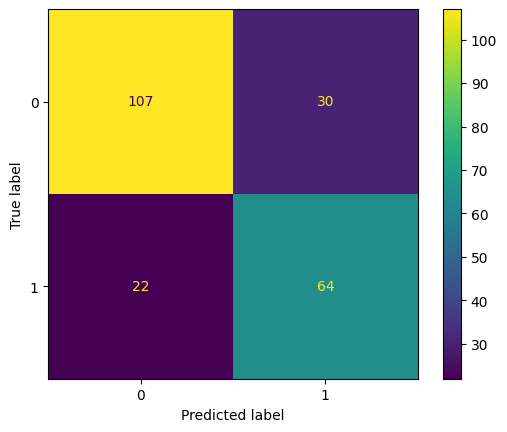

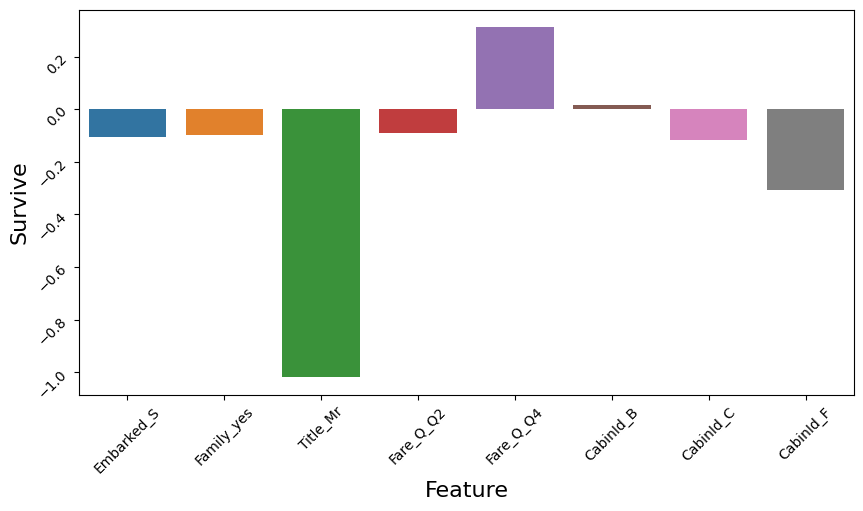

In [36]:
# RE-FIT USING BEST PARAMETERS
model_svc_opt = LinearSVC(C = 0.1, class_weight = 'balanced', dual = False, max_iter = 1000,
                    tol = 0.0001, fit_intercept=True, random_state = 0)
# RE-FIT MODEL
model_svc_opt.fit(X_train, y_train)
# USE MODEL TO MAKE PREDICTIONS ON TRIAL DATASET
preds_svc = model_svc_opt.predict(X_trial)
# MAKE PREDICTIONS ON TEST DATA
preds_svc_test = model_svc_opt.predict(Xncd_test)
# CLASSIFICATION REPORT FOR SVC MODEL
labels = ['Predicted not to survive', 'Predicted to survive']
print(classification_report(y_trial, preds_svc, target_names=labels))
# PLOT CONFUSION MATRIX FOR SVC MODEL
cm = confusion_matrix(y_trial, preds_svc, labels = model_svc_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_svc_opt.classes_)
disp.plot(values_format='')
plt.show()

# FEATURE IMPORTANCE WITHIN SVC MODEL
fig = plt.figure(figsize = (10,5))
ax1=sns.barplot(x=X_train.columns, y=model_svc_opt.coef_.flatten())
ax1.set_xlabel('Feature', fontsize=16)
ax1.set_ylabel('Survive', fontsize=16)
ax1.tick_params(rotation = 45)
fig.show()

## Fit model: Multinomial Naive Bayes Classifier ##

In [37]:
%%time
cv_params = {'alpha' : [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}
# INSTANTIATE MODEL
model_nb = MultinomialNB()
# SET CROSS-VALIDATION RUN
model_nb_val = GridSearchCV(model_nb, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)
# FIT THE MODEL
model_nb_val.fit(X_train, y_train)
# GET BEST PARAMETERS
print(model_nb_val.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.5}
CPU times: user 60.9 ms, sys: 3.78 ms, total: 64.7 ms
Wall time: 134 ms


                          precision    recall  f1-score   support

Predicted not to survive       0.74      0.80      0.77       137
    Predicted to survive       0.64      0.55      0.59        86

                accuracy                           0.70       223
               macro avg       0.69      0.67      0.68       223
            weighted avg       0.70      0.70      0.70       223



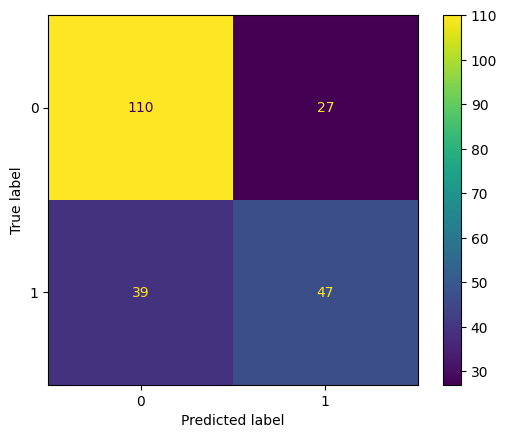

In [38]:
# RE-FIT USING BEST PARAMETERS
model_nb_opt = MultinomialNB(alpha=1.0)
# RE-FIT MODEL
model_nb_opt.fit(X_train, y_train)
# USE MODEL TO MAKE PREDICTIONS ON TRIAL DATASET
preds_nb = model_nb_opt.predict(X_trial)
# MAKE PREDICTIONS ON TEST DATA
preds_nb_test = model_nb_opt.predict(Xncd_test)
# CLASSIFICATION REPORT FOR NB MODEL
labels = ['Predicted not to survive', 'Predicted to survive']
print(classification_report(y_trial, preds_nb, target_names=labels))
# PLOT CONFUSION MATRIX FOR NB MODEL
cm = confusion_matrix(y_trial, preds_nb, labels = model_nb_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_nb_opt.classes_)
disp.plot(values_format='')
plt.show()


## Fit model: Bernoulli Naive Bayes Classifier ##

In [39]:
%%time
cv_params = {'alpha' : [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}
# INSTANTIATE MODEL
model_ber = BernoulliNB()
# SET CROSS-VALIDATION RUN
model_ber_val = GridSearchCV(model_ber, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)
# FIT THE MODEL
model_ber_val.fit(X_train, y_train)
# GET BEST PARAMETERS
print(model_ber_val.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.5}
CPU times: user 61.7 ms, sys: 5.25 ms, total: 66.9 ms
Wall time: 172 ms


                          precision    recall  f1-score   support

Predicted not to survive       0.80      0.75      0.77       137
    Predicted to survive       0.64      0.70      0.67        86

                accuracy                           0.73       223
               macro avg       0.72      0.72      0.72       223
            weighted avg       0.74      0.73      0.73       223



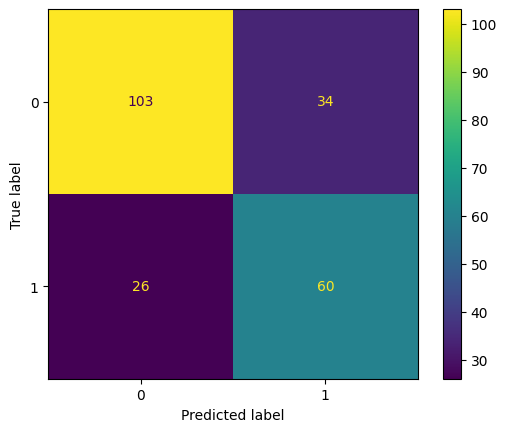

In [40]:
# RE-FIT USING BEST PARAMETERS
model_ber_opt = BernoulliNB(alpha=4.0)
# RE-FIT MODEL
model_ber_opt.fit(X_train, y_train)
# USE MODEL TO MAKE PREDICTIONS ON TRIAL DATASET
preds_ber = model_ber_opt.predict(X_trial)
# MAKE PREDICTIONS ON TEST DATA
preds_ber_test = model_ber_opt.predict(Xncd_test)
# CLASSIFICATION REPORT FOR NB MODEL
labels = ['Predicted not to survive', 'Predicted to survive']
print(classification_report(y_trial, preds_ber, target_names=labels))
# PLOT CONFUSION MATRIX FOR NB MODEL
cm = confusion_matrix(y_trial, preds_ber, labels = model_ber_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_ber_opt.classes_)
disp.plot(values_format='')
plt.show()


<div class="alert alert-block alert-warning">
<b>About logistical regression with subset of variables:</b>

* the model is better at predicting who did not survive
* one third of survivors were incorrectly predicted not to survive
</div>

## Stacking Classifier model ##

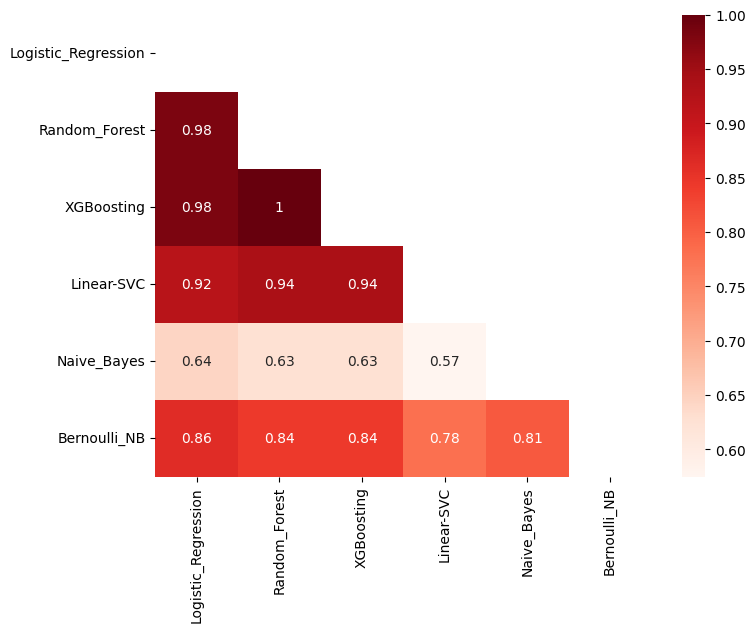

In [41]:
# BUILD INPUT FOR STACKING CLASSIFIER
x_stack=pd.DataFrame({'Logistic_Regression':preds_lg, 'Random_Forest':preds_rf, 'XGBoosting':preds_xgb, 'Linear-SVC':preds_svc, 'Naive_Bayes':preds_nb, 'Bernoulli_NB':preds_ber})
y_stack=pd.DataFrame({'Target':y_trial})
x_stack_test=pd.DataFrame({'Logistic_Regression':preds_lg_test, 'Random_Forest':preds_rf_test, 'XGBoosting':preds_xgb_test, 'Linear-SVC':preds_svc_test, 'Naive_Bayes':preds_nb_test, 'Bernoulli_NB':preds_ber_test})
# PLOT PEARSON CORRELATION FOR INPUT
corr = x_stack.corr()
uppertri = np.triu(corr)
fig = plt.figure(figsize=(8,6))
ax1=sns.heatmap(corr, annot=True, cmap='Reds', mask=uppertri)
fig.show()

In [42]:
# GET RID OF HIGHLY CORRELATED MODELS
x_stack = x_stack.drop(['Logistic_Regression'], axis=1)
x_stack_test = x_stack_test.drop(['Logistic_Regression'], axis=1)

In [44]:
%%time
# BUILD STACKING CLASSIFIER XGB MODEL
# DETERMINE HYPERPARAMETERS FOR CROSS-VALIDATION
cv_params = {'max_depth' : [4, 6, 8],
            'n_estimators' : [150, 200, 250],
            'learning_rate' : [0.1, 0.2, 0.3],
            'colsample_bytree' : [0.7, 0.8, 0.9],
            'min_child_weight': [5, 7, 10],
             'gamma' : [0.7, 0.8, 0.9],
            'subsample' : [0.5, 0.7, 0.9]}
# INSTANTIATE MODEL
xgb_stack = XGBClassifier(objective = 'binary:logistic')
# SET CROSS-VALIDATION RUN
xgb_stack_val = GridSearchCV(model_xgb, cv_params, cv=5, refit='f1', n_jobs = -1, verbose = 1)
# FIT THE MODEL
#xgb_stack_val.fit(x_stack, y_stack)
# GET BEST PARAMETERS
#print(xgb_stack_val.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
{'colsample_bytree': 0.7, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.5}
CPU times: user 13.5 s, sys: 561 ms, total: 14.1 s
Wall time: 2min 28s


In [45]:
# BEST FIT PARAMETERS
xgb_stack_opt = XGBClassifier(colsample_bytree = 0.7, gamma=0.7, learning_rate=0.1, max_depth = 4,
                                min_child_weight = 5, n_estimators = 150, subsample = 0.5, random_state = 0)
# RE-FIT MODEL
xgb_stack_opt.fit(x_stack, y_stack)
# USE MODEL TO MAKE PREDICTIONS ON TRIAL DATASET
preds_stack = xgb_stack_opt.predict(x_stack_test)

# CREATE OUTPUT FILE FOR SUBMISSION
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': preds_stack})
output.to_csv('submission.csv', index=False)